# Quantum SVM

This script's used as an initial search for a promising configuration. It uses smaller

## Importing

In [1]:
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
import numpy as np
import matplotlib.pyplot as plt

## Loading Real Backend

In [2]:
#setting up account 
from qiskit import IBMQ
account_token = ''
login_address = 'https://api.quantum-computing.ibm.com/api/Hubs/ibm-q/Groups/open/Projects/main'
#IBMQ.enable_account(account_token, login_address)

## Loading Iris Dataset

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# this is the iris loading part edited from the tutorial to return correct data structure. 
# The part reducing dimension with PCA is commented out. 
# Creation of test set is modified to allow test set size larger than 1. 
# train_size: integer, train set size per type of sample
# test_size: integer, test set size per type of sample
# If there's not enough sample, this method will return all available samples in the dataset.
# all data are standardized for gaussian around 0 with unit variance and scaled to range (-1, +1).

def Iris(train_size, test_size, PLOT_DATA=True, random_seed=666):
    if train_size > 150 or test_size > 150:
        raise Exception('Training or testing set shouldn\'t be larger than the size of IRIS, which is 150.')
    
    class_labels = [r'A', r'B', r'C']
    data, target = load_iris(True)
    test_ratio = float(test_size)/float(train_size + test_size)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=test_ratio, random_state=random_seed)

    # Now reduce number of features to number of qubits
    # pca = PCA(n_components=n).fit(sample_train)
    # sample_train = pca.transform(sample_train)
    # sample_test = pca.transform(sample_test)

    
    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)
    
    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    train_set = {key: (sample_train[label_train == k, :])[:train_size] for k, key in enumerate(class_labels)}
    test_set = {key: (sample_test[label_test == k, :])[:test_size] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:train_size],
                        sample_train[label_train == k, 1][:train_size])

        plt.title("train set")
        plt.show()
        
        for k in range(0, 3):
            plt.scatter(sample_test[label_test == k, 0][:test_size],
                        sample_test[label_test == k, 1][:test_size])

        plt.title("test set")
        plt.show()

    return train_set, test_set

## QSVM

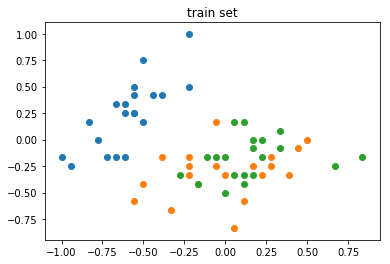

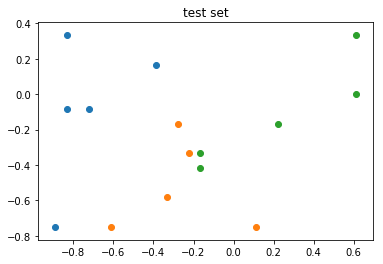

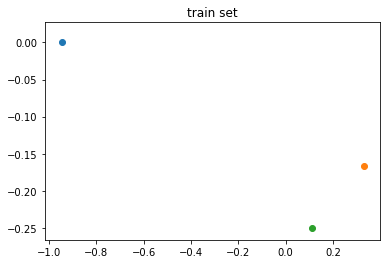

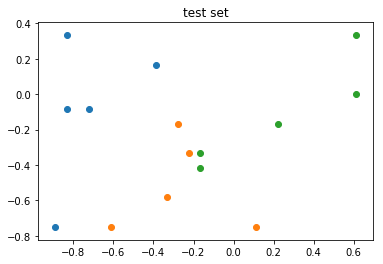

In [ ]:
from qiskit.aqua.components.feature_maps import SecondOrderExpansion, FirstOrderExpansion, PauliExpansion, self_product
#from qiskit.aqua.components.multiclass_extensions import AllPairs

feature_dim = 4 # Iris contains 4 features: sepal length, sepal width, petal length, petal width
feature_map_depth = 2 # circuit depth of feature map



# Making a list of feature maps to test in combination with all multiclass extensions


# Creating train and test sets from Iris dataset
train_set, test_set = Iris(20,5)
extra_train_set, extra_test_set = Iris(1,5)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_set)


# This part converts data from Iris method to the format required by QSVM.
temp = [test_set[k] for k in test_set]
total_array = np.concatenate(temp)
algo_input = ClassificationInput(train_set, test_set, total_array)


In [ ]:
#this method runs aqua with all possible combination of feature maps and multi-class expansions from a given config
def run_aqua(algo_input, real_backend = False, nshots = 1024):
    # This json object sets the basic config for the QSVM algorithm object. 
    # Since programmatic object themselves are not yet fully implemented in Aqua, 
    # this is the only possible way to define algorithm objects.
    
    #TODO: parameters for feature maps
    #TODO: 
    aqua_dict = {
        'problem': {'name': 'classification'},
        'algorithm': {'name': 'QSVM'},
        'backend': {},
        'multiclass_extension': {},
        'feature_map': {}
    }
    
    # This part defines backend
    if real_backend:
        aqua_dict['backend'] = {'provider': 'qiskit.IBMQ', 'name': 'ibmq_16_melbourne', 'shots': nshots}
    else:
        aqua_dict['backend'] =  {'provider': 'qiskit.BasicAer', 'name': 'qasm_simulator', 'shots': nshots}
        
    # list of all extensions and feature maps.
    extensions = [
       {'name': 'OneAgainstRest'},
       {'name': 'AllPairs'}, 
       {'name': 'ErrorCorrectingCode', 'code_size': 5}]

    feature_maps = [
       {'name': 'PauliExpansion', 'depth': 2, 'paulis':['Z', 'ZZ'], 'entanglement': 'full'},
       {'name': 'RawFeatureVector', 'feature_dimension': 4},
       {'name': 'PauliZExpansion', 'depth': 2, 'z_order': 2, 'entanglement': 'full'},
       {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'full'},
       # Linear entanglement means nearest neighbour entanglement
       {'name': 'FirstOrderExpansion', 'depth': 2}]
    
    # looping over them
    for extension in extensions:
        for feature_map in feature_maps:
            aqua_dict['multiclass_extension'] = extension
            aqua_dict['feature_map'] = feature_map
            result = run_algorithm(aqua_dict, algo_input)
            print("\n----- Using multiclass extension: '{}' -----\n".format(extension['name']))
            print("\n----- Using feature map: '{}' -----\n".format(feature_map['name']))
            for k,v in result.items():
                print("'{}' : {}".format(k, v))


In [ ]:
%%time
run_aqua(algo_input)


----- Using multiclass extension: 'OneAgainstRest' -----


----- Using feature map: 'PauliExpansion' -----

'testing_accuracy' : 0.8
'test_success_ratio' : 0.8
'predicted_labels' : [1 0 0 0 0 1 0 0 1 1 2 2 2 1 2]
'predicted_classes' : ['B', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'C', 'C', 'C', 'B', 'C']

----- Using multiclass extension: 'OneAgainstRest' -----


----- Using feature map: 'RawFeatureVector' -----

'testing_accuracy' : 0.5333333333333333
'test_success_ratio' : 0.5333333333333333
'predicted_labels' : [2 2 2 2 2 2 1 1 2 1 2 2 2 2 2]
'predicted_classes' : ['C', 'C', 'C', 'C', 'C', 'C', 'B', 'B', 'C', 'B', 'C', 'C', 'C', 'C', 'C']

----- Using multiclass extension: 'OneAgainstRest' -----


----- Using feature map: 'PauliZExpansion' -----

'testing_accuracy' : 0.8
'test_success_ratio' : 0.8
'predicted_labels' : [1 0 0 0 0 1 0 0 1 1 2 2 2 2 2]
'predicted_classes' : ['B', 'A', 'A', 'A', 'A', 'B', 'A', 'A', 'B', 'B', 'C', 'C', 'C', 'C', 'C']
